ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **17Feb21**

# 05. Poisson 1D MOOSE Application
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Dirichlet Boundary Condition Case](#dbc)
 + [Strong Form of Problem Statement](#dbcstrong)
 + [Weak Form of Problem Statement](#dbcweak)
 + [Problem Setup](#dbcsetup)
   - [Application](#dbcapp)
   - [Diffusion Term Kernel](#dbcdiff)
   - [Source Term Kernel](#dbcsource)
   - [Compile Application](#dbccompile)
   - [Input File](#dbcinput)
   - [Run App](#dbcrun)
 + [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Quadratic Lagrange FEM Results](#dbcquadfemresults)
1. [Constant Normal Flux Boundary Condition Case](#nbc)
 + [Strong Form of Problem Statement](#nbcstrong)
 + [Weak Form of Problem Statement](#nbcweak)
  + [Problem Setup](#nbcsetup)
   - ["Feeding" Boundary Condition (input file)](#nbcinput1)
   - [Run App](#nbcrun1)
   - [Quadratic Lagrange FEM Results](#nbcquadfemresults1)
   - ["Draining" Boundary Condition (input file)](#nbcinput2)
   - [Run App](#nbcrun2)
   - [Quadratic Lagrange FEM Results](#nbcquadfemresults2)
   
1. [Linear Transfer Normal Flux Boundary Condition Case](#rbc)
 + [Strong Form of Problem Statement](#rbcstrong)
 + [Weak Form of Problem Statement](#rbcweak)
 + [Problem Setup](#rbcsetup)
  - [Quadratic Lagrange FEM Results](#rbcquadfemresults1)
---

## [Objectives](#toc)<a id="obj"></a>

 + Begin using [`MOOSE`](https://mooseframework.inl.gov) to practice solving ODE's. Therefore access to a working [`MOOSE`](https://mooseframework.inl.gov) installation is necessary. Additional local information on installation for your computer setting can be found [here](https://github.com/UML-Linux-Club/moose-info).
 + Introduce the Galerkin weak form of the Poisson 1D problem below.
 + Introduce the use of the most common boundary conditions and their combinations: Dirichlet, Neumann, and Robin.
 + Use second order accurate finite element Lagrange basis functions to solve the problem numerically.
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. If you do not do a minimum of programing you will not learn basic aspects of this subject. Hands-on work during lectures will fill in this gap. If you do all the steps proposed in this notebook and attend the working lectures you will only have an initial knowledge of the subject.</span>

## [Dirichlet Boundary Condition Case](#toc)<a id="dbc"></a>

This section outlines the steps to obtain a working numerical solution of the Poisson 1D problem when using *Dirichlet boundary conditions*. The latter are conditions where a value of the unknown at the boundary points is given. This is also called an *essential* boundary condition.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Poisson model problem. Find $u:[a,b]\in\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 u(b) &= B.
\end{align*}
   
Solve this problem analytically for constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, and exit concentration $B$.The *flux* associated to the quantity $u$, is denoted $q := -D\,u$.

### [Weak Form of Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx + \int\limits_a^b S\,v(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\in\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1(a,b), v(a) = 0, v(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $v$ is called a test function. Because $v$ and $u$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

The two integrals in the weak formulation are the key terms to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integrals, that is, the kernels. Therefore the kernels needed are:

 1. $-D\, u'(x)\,v'(x)$ ,
 1. $S\,v(x)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

### [Problem Setup](#toc)<a id="dbcsetup"></a>

We need to create a MOOSE *application* with two MOOSE *kernels* and an *input* file. The ODE problem has a diffusion and a source term. Therefore a good way to proceed is to have two MOOSE kernels coded in C++ programming language.

#### [MOOSE App Creation](#toc)<a id="dbcapp"></a>

1. Make sure `MOOSE` has been installed an there was *no failed* tests.
1. `cd ~/moose`
1. `cd ..`
1. `./moose/scripts/stork.sh Engy5310P1`
1. Disregard the `github` setup
1. `cd engy5310p1`
1. `make`
1. `./run_tests`
1. `cp test/tests/kernels/simple_diffusion/simple_diffusion.i input.i`
1. Cleanup: `rm -rf test/, unit/, doc/, scripts/, and run_tests`
1. Edit `src/main.C`
 - Replace `Engy5310P1TestApp` with `Engy5310P1App`
1. `make clean`
1. `make`
1. Test run 
 + `./engy5310p1-opt -i input.i`
1. Use [`VisIt`](https://wci.llnl.gov/simulation/computer-codes/visit) or `Paraview` to visualize `test_out.e`

#### [Add a Diffusion Term Kernel](#toc)<a id="dbcdiff"></a>
1. `cd include`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.h` class interface as folows:
 + Use the `EquationTerm.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.h) as follows:
 + `cp *path-to*/moose-app-templates/EquationTerm.h .`
 + `mv EquationTerm.h DiffusionTerm.h`
 + Edit the file `EquationTerm.h` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to declare a member variable named `_diffCoeff` as `Real` data type.
1. `cd ../..`
1. `cd src`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.C` class implementation as follows:
 + Use the `EquationTerm.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.C) as follows.
 + `cp *path-to*/moose-app-templates/EquationTerm.C .`
 + `mv EquationTerm.C DiffusionTerm.C`
 + Edit the file `EquationTerm.C` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is done in class.</span>

#### [Add a Source Term Kernel](#toc)<a id="dbcsource"></a>
1. `cd include`
1. `mkdir kernels`
1. Create a `SourceTerm.h` class interface following similar steps as done for the `DiffusionTerm.h` interface.
 + Use the `EquationTerm.h` course template.
 + You will need to declare a member variable named `_sourceS` as `Real` data type.
1. Create a `SourceTerm.C` class implementation likewise.
 + Use the `EquationTerm.h` course template.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is done in class.</span>

#### [Compile and Link Application](#toc)<a id="dbccompile"></a>

1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

#### [Input File](#toc)<a id="dbcinput"></a>

Any line in the "blocked MOOSE input format information below" without a comment (any text to the righ of *#*) refers to a MOOSE framework parameter. Consult the documentation for further info on these parameters. All user-app parameters for this problem are described with comments below. Use the content below to create an `input.i` input file. That is, using a text editor copy and paste the content below into a new file and save it as a `text` file format with name `input.i`.
```
[Mesh]
 [1d]                                # any lower case name; this is our 1D block
  type = GeneratedMeshGenerator  
  dim = 1 
  xmin = 0 
  xmax = 25
  nx = 1 
 []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = first
  family = lagrange
 []
[]

[Kernels]
 [diffusion-term]                    # our diffusion term kernel implemented in the app
  type = DiffusionTerm               # our name for the diffusion kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  diffCoeff = 1.00000e-01            # our defined diffusion coefficient C++ variable
 []
 [source-term]                       # our source term kernel implemented in the app
  type = SourceTerm                  # our name for the source kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  sourceS = 1.0000e-03               # our defined source constant C++ variable
 []
[]

[BCs]
 [entry]                             # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = left
  value = 3.00000e+00
 []
 [exit]                              # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = right
  value = 0.0
 []
[]

[Executioner]
 type = Steady
 solve_type = 'PJFNK'
 petsc_options_iname = '-pc_type -pc_hypre_type'
 petsc_options_value = 'hypre boomeramg'
[]

[VectorPostprocessors]
 [u]                                 # our unknown variable
  type = LineValueSampler
  execute_on = 'timestep_end final'
  variable = 'u'                     # our unknown variable from the [Variables] block
  start_point = '0 0 0'
  end_point = '25 0 0'
  num_points = 7
  sort_by = id
 []
[]

[Outputs]
 [csv]                              # our choice for data output: tabular
  type = CSV
  file_base = 'output'
  execute_on = 'final'
 []
[]

```
Save the input file in the `.../engy5310p1/` directory.

#### [Run Application](#toc)<a id="dbcrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

### [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 3

In [1]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3
u_b = 0

diff_coeff = 0.1
source_s = 1e-3

n_felem = 3
order = 'first'
n_plot_pts = 2*n_felem + 1

from engy_5310.toolkit import write_engy5310_p1_input_file

write_engy5310_p1_input_file(x_a, x_b, u_a=u_a, u_b=u_b, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts)

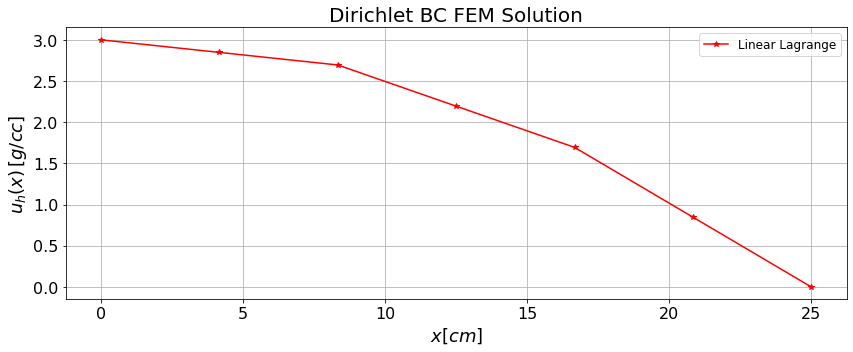

In [2]:
'''Show FEM Solution'''

import pandas as pd

df = pd.read_csv('engy5310p1/output_u_0002.csv')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 5))
plt.plot(df['x'], df['u'],'r*-',label='Linear Lagrange')
plt.title('Dirichlet BC FEM Solution', fontsize=20)
plt.ylabel(r'$u_h(x)\,[g/cc]$', fontsize=18)
plt.xlabel(r'$x [cm]$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**Comments:**

1. The *concentration* drops from the entry value to the exit as prescribed by the boundary conditions.
1. Because of the source term the profile is quadratic.
1. Since the linear Lagrange basis functions are used with 3 finite elements, 3 linear sections approximate the solution.

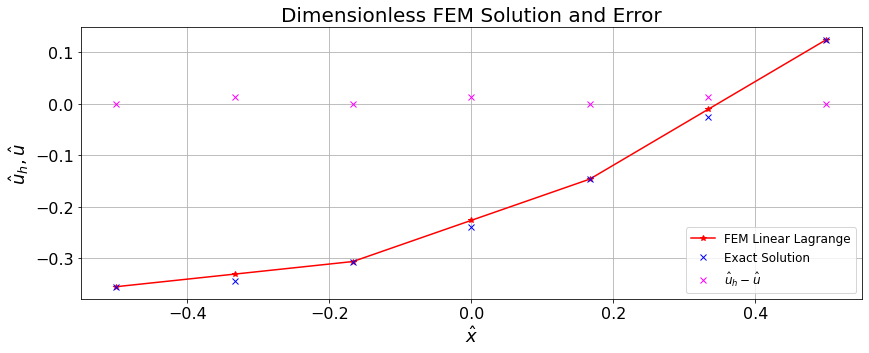

In [3]:
'''Error Compared to Exact Dimensionless Solution'''

from engy_5310.toolkit import engy5310_p1_exact_solution

u_hat = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

L = df['x'].max() - df['x'].min()
x_hat = (df['x'] - df['x'].min())/L - 0.5

C = - source_s / diff_coeff
uh_hat = df['u']/C/L**2 + 1/8

plt.figure(1, figsize=(14, 5))
plt.plot(x_hat, uh_hat,'r-*',label='FEM Linear Lagrange')
plt.plot(x_hat, u_hat.values(x_hat),'bx',label='Exact Solution')
plt.plot(x_hat, uh_hat-u_hat.values(x_hat),'x',color='magenta',label=r'$\hat{u}_h-\hat{u}$')
plt.title('Dimensionless FEM Solution and Error', fontsize=20)
plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
plt.xlabel(r'$\hat{x}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()



**Comments:**

1. Error as compared to the exact dimensionless solution is zero at the boundary of the linear sections but not in between.

### [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [4]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3
u_b = 0

diff_coeff = 0.1
source_s = 1e-3

n_felem = 1
order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

from engy_5310.toolkit import write_engy5310_p1_input_file

write_engy5310_p1_input_file(x_a, x_b, u_a=u_a, u_b=u_b, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts)

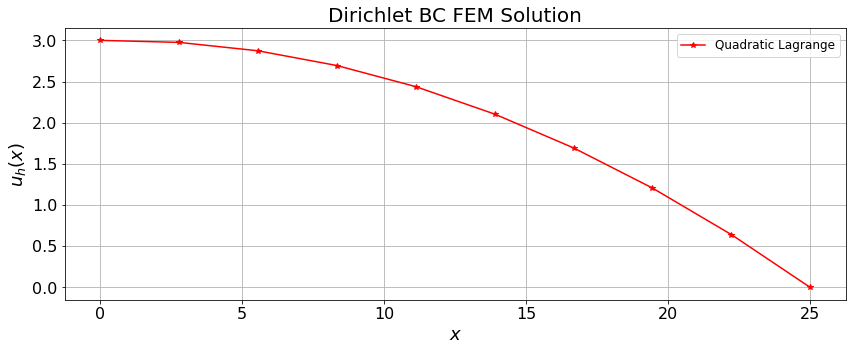

In [5]:
'''Show FEM Solution'''

import pandas as pd

df = pd.read_csv('engy5310p1/output_u_0002.csv')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 5))
plt.plot(df['x'], df['u'],'r*-',label='Quadratic Lagrange')
plt.title('Dirichlet BC FEM Solution', fontsize=20)
plt.ylabel(r'$u_h(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

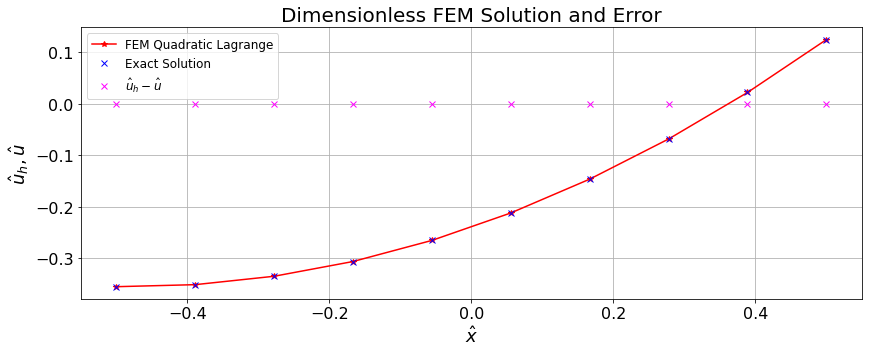

In [7]:
'''Error'''

from engy_5310.toolkit import engy5310_p1_exact_solution

u_hat = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

L = df['x'].max() - df['x'].min()
x_hat = (df['x'] - df['x'].min())/L - 0.5

c = - source_s / diff_coeff
uh_hat = df['u']/c/L**2 + 1/8

plt.figure(1, figsize=(14, 5))
plt.plot(x_hat, uh_hat,'r-*',label='FEM Quadratic Lagrange')
plt.plot(x_hat, u_hat.values(x_hat),'bx',label='Exact Solution')
plt.plot(x_hat, uh_hat-u_hat.values(x_hat),'x',color='magenta',label=r'$\hat{u}_h-\hat{u}$')
plt.title('Dimensionless FEM Solution and Error', fontsize=20)
plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
plt.xlabel(r'$\hat{x}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()



## [Constant-Normal-Flux Boundary Condition Case](#toc)<a id="nbc"></a>

The diffusive flux associated to $u$ is defined as

\begin{equation*}
 q(x) := -D\,u'(x).
\end{equation*}

The normal diffusive flux evaluated at boundary points is defined in 1D as:

\begin{align*}
 q_n(a) &:= - q(a),  \\
 q_n(b) &:= q(b).
\end{align*}

Therefore a positive value of normal flux $q_n$ at any boundary point indicates that the quantity $u$ is removed. Otherwise it is added at the respective boundary point. The *normal* qualification here refers to the direction of the outward pointing vector at the boundary. Since this is a 1D problem, at the exit $b$, the normal aligns with the coordinate $x$ direction. At $a$ the normal is pointing in the opposite direction of the coordinate system.

In the literature, the Neumann boundary condition is given on the *derivative* (or gradient) of the unknown variable. This is not as useful as giving information on the *normal* diffusive flux $q_n$ associated to $u$.

Here we will employ a mix of Dirichlet boundary condition on the entry point and a normal flux boundary condition on the exit point. That is:

\begin{align*}
 u(a) &= A, \\
 -D\,u'(b) &= q_b = q_n(b),
\end{align*}

where $q_b$ is the value to be specified. If this value is positive, $u$  will be depleted at the boundary.

### [Strong Form of Problem Statement](#toc)<a id="nbcstrong"></a>

Solve the Poisson model problem. Find $u:[a,b]\in\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 q_n(b) &= q_b.
\end{align*}
   
Solve this problem analytically for the constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, and exit flux, $q_b$. 

### [Weak Form of Problem Statement](#toc)<a id="nbcweak"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx + \int\limits_a^b S\,v(x)\,dx - q_n(b)\,v(b) &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\in\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1\!\bigl([a,b]\bigr), v(a) = 0 \bigr\}$. This weak form is a modified Galerkin's weak form including the Neumann boundary condition.

### [Problem Setup](#toc)<a id="nbcsetup"></a>

The previously developed code for the Dirichlet boundary condition case remains unchanged and usable.
We will create our own boundary condition kernel.

#### ["Feeding" Boundary Condition (input file)](#toc)<a id="nbcinput1"></a>

The *feeding* boundary condition uses a negative normal diffusive flux at the exit point, therefore there exists diffusive *feed* of material at that point.

Using the previous `input.i` input file (edit with a text editor), modify the `exit` block as follows:

```
[exit]
  type = NormalFluxBC
  variable = u
  boundary = right
  bias = -0.5
[]
```


Save the input file in the `.../engy5310p1/` directory.

#### [Run Application](#toc)<a id="nbcrun1"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

#### [Quadratic Lagrange FEM](#toc)<a id="nbcquadfemresults1"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = -0.5 g/cm^2-s
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [12]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3

diff_coeff = 0.1
source_s = 5e-2

qn_b = -0.5 # feeding on the exit boundary; normal flux is negative

n_felem = 1
order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

from engy_5310.toolkit import write_engy5310_p1_input_file

write_engy5310_p1_input_file(x_a, x_b, u_a=u_a, u_bias=qn_b, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts)

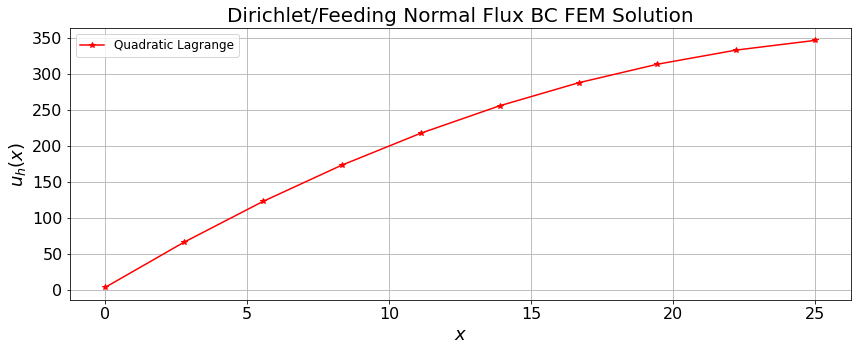

In [13]:
'''Show FEM Solution'''

import pandas as pd

df = pd.read_csv('engy5310p1/output_u_0002.csv')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 5))
plt.plot(df['x'], df['u'],'r*-',label='Quadratic Lagrange')
plt.title('Dirichlet/Feeding Normal Flux BC FEM Solution', fontsize=20)
plt.ylabel(r'$u_h(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**Comments:**

1. Because the normal flux at the exit is specified as negative, there is incoming diffusion into the domain, hence the concentration is higher at the exit than the entry point. The average concentration in the domain is greatly increased at steady state.
1. Note that 1 finite element was used.

#### ["Draining" Boundary Condition (input file)](#toc)<a id="nbcinput2"></a>

The *draining* boundary condition uses a positive normal diffusive flux at the exit point, therefore there exists diffusive *removal* of material at that point.

Using the previous `input.i` input file (edit with a text editor), modify the `exit` block as follows:

```
[exit]
  type = NormalFluxBC
  variable = u
  boundary = right
  bias = 0.62
[]
```


Save the input file in the `.../engy5310p1/` directory.

#### [Run Application](#toc)<a id="nbcrun2"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

#### [Quadratic Lagrange FEM](#toc)<a id="nbcquadfemresults2"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = 0.62 g/cm^2-s
> + D = 0.1 cm^2/s
> + S = 5e-2 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [23]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3

diff_coeff = 0.1
source_s = 5e-2

qn_b = 0.4 # draining on the exit boundary; normal flux is positive

n_felem = 1
order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

from engy_5310.toolkit import write_engy5310_p1_input_file

write_engy5310_p1_input_file(x_a, x_b, u_a=u_a, u_bias=qn_b, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts)

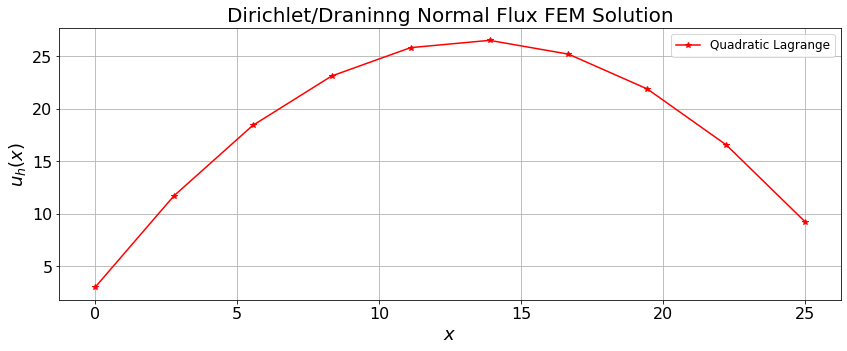

In [24]:
'''Show FEM Solution'''

import pandas as pd

df = pd.read_csv('engy5310p1/output_u_0002.csv')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 5))
plt.plot(df['x'], df['u'],'r*-',label='Quadratic Lagrange')
plt.title('Dirichlet/Draninng Normal Flux FEM Solution', fontsize=20)
plt.ylabel(r'$u_h(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**Comments:**

1. Because the flux at the exit is specified as positive, there is outgoing diffusion at the exit point of the domain, hence despite the constant source, the exit concentration is reduced to levels near the entry concentration. If the specified flux is too high compared to the source (or the source small compared to the flux) it will drive the concentration values at the exit to unphysical negative values.
1. Note that 1 finite element was used.

## [Linear Transfer Normal Flux Boundary Condition Case](#toc)<a id="rbc"></a>

A linear transfer condition imposed on the normal flux is a model for relating the unknown variable $u$ to external conditions of transport. Here the simplest linear case is the boundary condition

\begin{equation*}
 q(b) := h\,(u - u_\infty)
\end{equation*}

where $h\ge 0$ is a *transport coefficient* and $u_\infty$ is a reference value away from the exit point that drives the flux. Therefore this condition of transfer drives the variable $u$ towards $u_\infty$.

In the literature, this boundary condition is related to the Robin boundary condition which is given on the *derivative* (or gradient) of the unknown variable. This is not as useful as giving information on the *normal* diffusive flux $q_n$ associated to $u$.

### [Strong Form of Problem Statement](#toc)<a id="rbcstrong"></a>

Solve the Poisson model problem. Find $u:[a,b]\in\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 q(b) &=  h\,(u - u_\infty).
\end{align*}
   
Solve this problem analytically for the constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, mass transfer coefficient, $h$, and driving force concentration, $u_\infty$. 

### [Weak Form of Problem Statement](#toc)<a id="rbcweak"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx + \int\limits_a^b S\,v(x)\,dx - h\,\bigl(u(b) - u_\infty\bigr)\,v(b) &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\in\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1\!\bigl([a,b]\bigr), v(a) = 0 \bigr\}$. This weak form is a modified Galerkin's weak form including the Neumann boundary condition.

### [Problem Setup](#toc)<a id="rbcsetup"></a>

The previously developed code for the Neumann boundary condition case remains usable.
However we will need to create and add a boundary condition kernel in `MOOSE`.

#### [Add a BC Term Kernel](#toc)<a id="rbcbckernel"></a>
1. `cd include`
1. `mkdir bckernels`
1. `cd kernels`
1. Create a `DiffusionTerm.h` class interface as folows:
 + Use the `EquationTerm.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.h) as follows:
 + `cp *path-to*/moose-app-templates/EquationTerm.h .`
 + `mv EquationTerm.h DiffusionTerm.h`
 + Edit the file `EquationTerm.h` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to declare a member variable named `_diffCoeff` as `Real` data type.
1. `cd ../..`
1. `cd src`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.C` class implementation as follows:
 + Use the `EquationTerm.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.C) as follows.
 + `cp *path-to*/moose-app-templates/EquationTerm.C .`
 + `mv EquationTerm.C DiffusionTerm.C`
 + Edit the file `EquationTerm.C` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is done in class.</span>

#### [Quadratic Lagrange FEM](#toc)<a id="rbcquadfemresults1"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + h = 0.5 cm/s
> + u_infinity = 10 g/cc
> + D = 0.1 cm^2/s
> + S = 5e-2 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [38]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3

mass_transfer_coeff = 0.1
u_infinity = 5             # external reference value

diff_coeff = 0.1
source_s = 5e-2

n_felem = 2
order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

from engy_5310.toolkit import write_engy5310_p1_input_file

write_engy5310_p1_input_file(x_a, x_b, u_a=u_a, 
                             u_bias=0.0, transfer_coeff=mass_transfer_coeff, u_reference=u_infinity, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts)

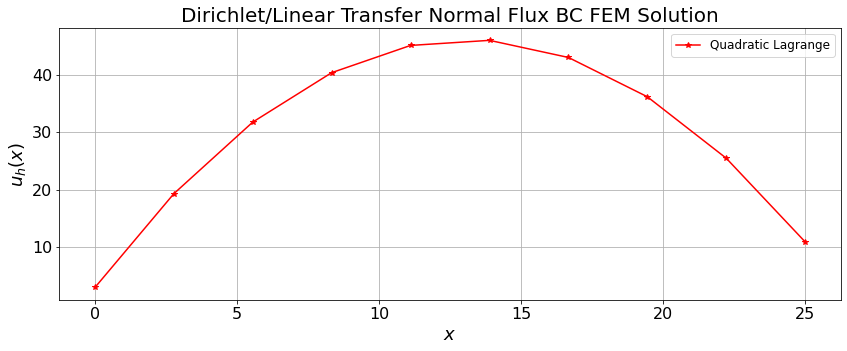

In [39]:
'''Show FEM Solution'''

import pandas as pd

df = pd.read_csv('engy5310p1/output_u_0002.csv')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 5))
plt.plot(df['x'], df['u'],'r*-',label='Quadratic Lagrange')
plt.title('Dirichlet/Linear Transfer Normal Flux BC FEM Solution', fontsize=20)
plt.ylabel(r'$u_h(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()